# BERTopic Hyperparameter Optimization (Supervised Approach)

In this notebook, I applied BERTopic to perform topic modeling on textual data. First, I used an unsupervised approach to automatically discover latent topics based on semantic similarity between documents.

Next, I optimized key model hyperparameters to improve topic quality, evaluating the results using topic coherence, topic diversity, and the number of topics. This allowed me to select a configuration that balances interpretability and topic separation.

Finally, I applied supervised topic modeling by incorporating predefined report sections as labels. This helped generate more structured and interpretable topics aligned with the report structure.

Overall, the notebook demonstrates a complete topic modeling workflow, from exploration to optimization and evaluation.


In [5]:
import pandas as pd

df = pd.read_csv("outputs\cleaned_df.csv")
docs_all = df["text"].tolist()


In [6]:
tokenized_docs = [d.split() for d in docs_all]


UNSUPERVISED TOPIC MODELING (BERTopic)

In [7]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(
    docs_all,
    show_progress_bar=True
)


c:\Users\ozdil\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 565/565 [21:18<00:00,  2.26s/it]  


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words="english",
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 2)
)


In [9]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(
    n_neighbors=10,
    n_components=5,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean"
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics="auto",        # safety net
    verbose=True
)


In [10]:
topics, probs = topic_model.fit_transform(docs_all, embeddings)


2026-01-03 21:00:23,265 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-03 21:01:10,250 - BERTopic - Dimensionality - Completed ✓
2026-01-03 21:01:10,250 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-03 21:01:16,849 - BERTopic - Cluster - Completed ✓
2026-01-03 21:01:16,865 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-01-03 21:01:27,423 - BERTopic - Representation - Completed ✓
2026-01-03 21:01:27,431 - BERTopic - Topic reduction - Reducing number of topics
2026-01-03 21:01:35,396 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-03 21:01:46,695 - BERTopic - Representation - Completed ✓
2026-01-03 21:01:46,723 - BERTopic - Topic reduction - Reduced number of topics from 2254 to 964


In [11]:
topic_model.get_topic_info().head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,5168,-1_prison_police_law_detention,"[prison, police, law, detention, authorities, ...",[Worker Rights Share a. Freedom of Association...
1,0,1866,0_labor_workers_child labor_unions,"[labor, workers, child labor, unions, work, em...",[Worker Rights Share a. Freedom of Association...
2,1,1768,1_detainees_detention_defendants_prisoners,"[detainees, detention, defendants, prisoners, ...",[or her. Police promptly informed detainees of...
3,2,568,2_elections_free fair_election_participation,"[elections, free fair, election, participation...",[Respect for Political Rights: The Right of Ci...
4,3,564,3_corruption_disclosure_public access_financia...,"[corruption, disclosure, public access, financ...",[Corruption and Lack of Transparency in Govern...


In [12]:
valid_topic_ids = [
    t for t in set(topics)
    if t != -1
]

len(valid_topic_ids)


963

In [17]:
def extract_topic_words(model, topic_ids, topn=10):
    topic_words = []

    for tid in topic_ids:
        topic = model.get_topic(tid)

        # 🔴 skip empty or invalid topics
        if topic is None:
            continue

        words = [w for w, _ in topic if isinstance(w, str)]

        if len(words) >= 2:  # Gensim needs at least 2 words
            topic_words.append(words[:topn])
       


    return topic_words


In [14]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def coherence_cv(tokenized_docs, topic_words):
    dictionary = Dictionary(tokenized_docs)

    # 🔵 remove words not in dictionary
    filtered_topics = [
        [w for w in topic if w in dictionary.token2id]
        for topic in topic_words
    ]

    filtered_topics = [t for t in filtered_topics if len(t) >= 2]

    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

    cm = CoherenceModel(
        topics=filtered_topics,
        texts=tokenized_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v"
    )

    return cm.get_coherence()


In [20]:

def topic_diversity(topic_words, topk=10):
    all_words = []
    for words in topic_words:
        all_words.extend(words[:topk])
    return len(set(all_words)) / len(all_words)




In [21]:
topic_words = extract_topic_words(
    topic_model,
    valid_topic_ids,
    topn=10
)

len(topic_words)

963

In [22]:
coh = coherence_cv(tokenized_docs, topic_words)
div = topic_diversity(topic_words)


(np.float64(0.6647701314333629), 0.7159916926272066)

hyperparametr optimization

In [23]:
base_params = {
    "n_neighbors": 10,
    "n_components": 5,
    "min_cluster_size": 3,
    "min_samples": 1
}


In [24]:
configs = [
    {**base_params},  # baseline
    {**base_params, "min_cluster_size": 5},
    {**base_params, "n_neighbors": 15},
]


In [25]:
def build_model_from_params(params):
    umap_model = UMAP(
        n_neighbors=params["n_neighbors"],
        n_components=params["n_components"],
        metric="cosine",
        random_state=42
    )

    hdbscan_model = HDBSCAN(
        min_cluster_size=params["min_cluster_size"],
        min_samples=params["min_samples"],
        metric="euclidean"
    )

    model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        nr_topics="auto",
        verbose=False
    )

    return model


In [26]:
results = []

for i, params in enumerate(configs):
    print(f"Running config {i+1}: {params}")

    model = build_model_from_params(params)
    topics, _ = model.fit_transform(docs_all, embeddings)

    valid_topic_ids = [t for t in set(topics) if t != -1]

    topic_words = extract_topic_words(model, valid_topic_ids, topn=10)

    if len(topic_words) < 2:
        print("  → skipped (too few valid topics)")
        continue

    coh = coherence_cv(tokenized_docs, topic_words)
    div = topic_diversity(topic_words)

    results.append({
        "config_id": i + 1,
        **params,
        "n_topics": len(topic_words),
        "coherence_c_v": coh,
        "topic_diversity": div
    })


Running config 1: {'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 3, 'min_samples': 1}
Running config 2: {'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 5, 'min_samples': 1}
Running config 3: {'n_neighbors': 15, 'n_components': 5, 'min_cluster_size': 3, 'min_samples': 1}


In [27]:
results_df = pd.DataFrame(results)
results_df


,config_id,n_neighbors,n_components,min_cluster_size,min_samples,n_topics,coherence_c_v,topic_diversity
0,1,10,5,3,1,963,0.664770,0.715992
1,2,10,5,5,1,344,0.681428,0.647674
2,3,15,5,3,1,528,0.659843,0.730492


In [28]:
results_df["score"] = (
    0.7 * results_df["coherence_c_v"] +
    0.3 * results_df["topic_diversity"]
)

results_df.sort_values("score", ascending=False)


,config_id,n_neighbors,n_components,min_cluster_size,min_samples,n_topics,coherence_c_v,topic_diversity,score
2,3,15,5,3,1,528,0.659843,0.730492,0.681038
0,1,10,5,3,1,963,0.664770,0.715992,0.680137
1,2,10,5,5,1,344,0.681428,0.647674,0.671302


In [31]:
best_params = results_df.sort_values(
    "score", ascending=False
).iloc[0]

best_params = {
    "n_neighbors": int(best_params["n_neighbors"]),
    "n_components": int(best_params["n_components"]),
    "min_cluster_size": int(best_params["min_cluster_size"]),
    "min_samples": int(best_params["min_samples"]),
}


In [32]:
best_model = build_model_from_params(best_params)
topics, _ = best_model.fit_transform(docs_all, embeddings)


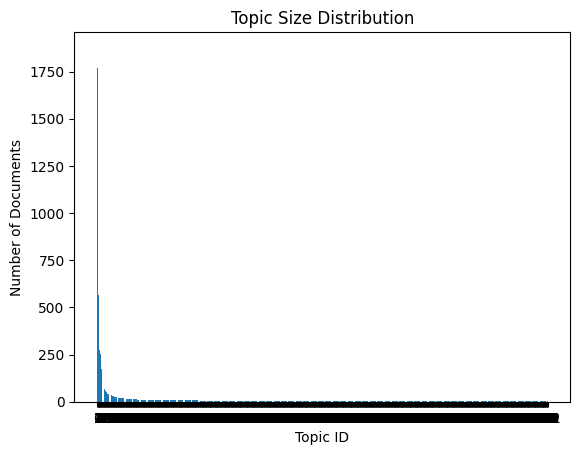

In [34]:
import matplotlib.pyplot as plt

topic_info = topic_model.get_topic_info()
topic_info = topic_info[topic_info.Topic != -1]

plt.figure()
plt.bar(
    topic_info.Topic.astype(str),
    topic_info.Count
)
plt.xlabel("Topic ID")
plt.ylabel("Number of Documents")
plt.title("Topic Size Distribution")
plt.show()


In [37]:
best_model.get_topic_info()
for t in range(5):
    print(f"Topic {t}:")
    print(best_model.get_topic(t))
    print()


Topic 0:
[('detention', np.float64(0.0029580390285215805)), ('freedom', np.float64(0.00282440746576462)), ('prisoners', np.float64(0.0028173743446401624)), ('detainees', np.float64(0.0027970893700541314)), ('refugees', np.float64(0.002780070836366415)), ('human rights', np.float64(0.0025570121529238797)), ('asylum', np.float64(0.0025470576599303323)), ('prison', np.float64(0.002485806338356374)), ('human', np.float64(0.0024849442104376705)), ('authorities', np.float64(0.0024038423301825313))]

Topic 1:
[('labor', np.float64(0.008276379047601378)), ('workers', np.float64(0.007358521487765207)), ('child labor', np.float64(0.005892286946753971)), ('work', np.float64(0.005568592510120808)), ('unions', np.float64(0.005452621264730745)), ('employers', np.float64(0.0050356434416536245)), ('sector', np.float64(0.004946590430178796)), ('minimum', np.float64(0.004842349792911862)), ('union', np.float64(0.004788429669564907)), ('employment', np.float64(0.004687840661544371))]

Topic 2:
[('corrupt

In [38]:
best_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5238,-1_rights_police_authorities_law,"[rights, police, authorities, law, human, pers...",[during the year. The Irish Film Classificatio...
1,0,4783,0_detention_freedom_prisoners_detainees,"[detention, freedom, prisoners, detainees, ref...","[Respect for Civil Liberties, Including: Share..."
2,1,1934,1_labor_workers_child labor_work,"[labor, workers, child labor, work, unions, em...",[Worker Rights Share a. Freedom of Association...
3,2,816,2_corruption_disclosure_financial_public access,"[corruption, disclosure, financial, public acc...",[Corruption and Lack of Transparency in Govern...
4,3,518,3_international child_marriage_disabilities_child,"[international child, marriage, disabilities, ...","[in state care, but it remained legal elsewher..."
...,...,...,...,...,...
524,523,3,523_percent concerned_concerned right_victims ...,"[percent concerned, concerned right, victims c...",[matrimonial real property rights and interest...
525,524,3,524_rape victims_reported attacks_disfiguremen...,"[rape victims, reported attacks, disfigurement...",[to reinstate certain provisions of the 1979 H...
526,525,3,525_skopje_zaev_basic court_court skopje,"[skopje, zaev, basic court, court skopje, skop...",[Fernandez’s trial continued as of December. e...
527,526,3,526_direct_participating political_parties_gov...,"[direct, participating political, parties, gov...",[authorities to suspend parties for six months...


In [39]:
docs = best_model.get_representative_docs(1)

for d in docs[:3]:
    print(d[:300])
    print("----")


Worker Rights Share a. Freedom of Association and the Right to Collective Bargaining The law provides for the right to form and join independent unions, conduct legal strikes, and bargain collectively. The law prohibits antiunion discrimination and any restriction or obstruction of these rights. The
----
in family-owned cottage industries. There were also reports of commercial sexual exploitation of children (see section 6, children). See the Department of Labor’s Findings on the Worst Forms of Child Labor at www.dol.gov/ilab/reports/child-labor/findings/ . d. Discrimination with Respect to Employme
----
incidences of the worst forms of child labor occurred, mainly in gold mining, prostitution, and forced labor activities including domestic servitude. According to local NGOs, children who worked in gold mines operated dangerous mining equipment and were exposed to hazardous chemicals, including merc
----


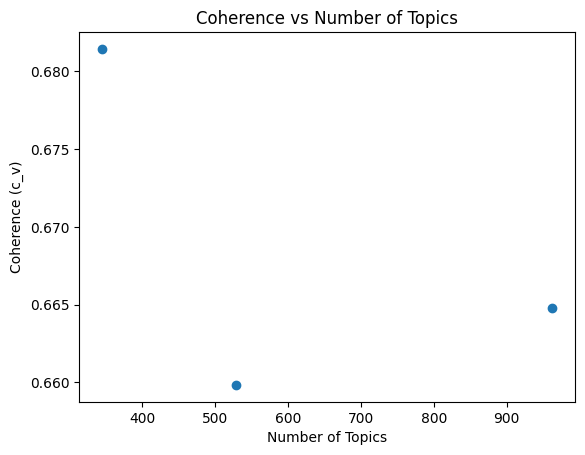

In [41]:
plt.figure()
plt.scatter(
    results_df["n_topics"],
    results_df["coherence_c_v"]
)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence (c_v)")
plt.title("Coherence vs Number of Topics")
plt.show()


SUPERVISED TOPIC MODELING BY REPORT SECTION

In [ ]:
df["section"].value_counts().head()

In [ ]:
sections = [ "Section 1.", "Section 6.", "Section 2."]

In [ ]:
def run_bertopic_on_subset(docs, embeddings_subset=None):
    topics, _ = topic_model.fit_transform(docs, embeddings_subset)
    topic_info = topic_model.get_topic_info()
    topic_info = topic_info[topic_info.Topic != -1]  # remove outliers
    return topic_info


In [ ]:
results_by_section = {}

for sec in sections:
    subset = df[df["section"] == sec]["text"].tolist()

    if len(subset) < 100:
        continue  # skip tiny sections

    topics, _ = topic_model.fit_transform(subset)

    results_by_section[sec] = topic_model.get_topic_info()


In [ ]:
for sec, info in results_by_section.items():
    print(f"\n=== {sec} ===")
    display(info.head(5))


In [ ]:
comparison_rows = []

for sec, info in results_by_section.items():
    for _, row in info.iterrows():
        comparison_rows.append({
            "section": sec,
            "topic_id": row["Topic"],
            "n_documents": row["Count"],
            "top_words": row["Name"]
        })

comparison_df = pd.DataFrame(comparison_rows)
comparison_df.head()


In [ ]:
comparison_df.sort_values(
    ["section", "n_documents"],
    ascending=[True, False]
).head(15)


In [ ]:
topic_counts = comparison_df.groupby("section")["topic_id"].nunique()
topic_counts
